<a href="https://colab.research.google.com/github/100495962/AA_P2_100495962_100495954/blob/main/NotebookP2_Grupo18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NOTEBOOK - PRÁCTICA 2** #

**Autores:**
- **Hugo Cuevas Romera [100495962]**
- **Pablo Lorenzo Martín [100495954]**

**Grupo: Nº18**

**Enlace Repositorio GitHub: https://github.com/100495962/AA_P2_100495962_100495954.git**

# **INTRODUCCIÓN** #

En esta práctica aplicaremos técnicas de *aprendizaje no supervisado*, concretamente de **clustering**, para explorar y analizar un conjunto de datos sobre semillas. Nuestro objetivo es descubrir si existen agrupaciones naturales en los datos, analizar cómo se corresponden con las clases reales de semillas y evaluar qué método de agrupamiento ofrece los mejores resultados.

Utilizaremos las siguientes técnicas de clustering:
- K-Means
- Clustering Jerárquico (con dendrogramas)
- DBSCAN

Además, emplearemos reducción de dimensionalidad con **PCA** para visualizar los datos en 2D, y evaluaremos el efecto de diferentes técnicas de escalado.

# **CARGA Y EXPLORACIÓN DE DATOS** #

Cargamos el conjunto de datos `semillas.csv`, que contiene medidas de diferentes tipos de semillas. Estas medidas incluyen características como el área, perímetro, compacidad, longitud y ancho, entre otras. Además, el dataset incluye una columna de clase que identifica el tipo de semilla, aunque esta no será utilizada durante la fase de agrupamiento, ya que se trata de un problema no supervisado.

En esta sección exploramos brevemente la estructura de los datos, verificamos que no haya valores nulos y observamos algunas estadísticas descriptivas para tener una primera idea de la distribución de las variables.


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para escalado, reducción de dimensionalidad y clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Configuración gráfica
sns.set(style='whitegrid')
%matplotlib inline

# Fijar semilla para reproducibilidad
np.random.seed(18)  # Grupo 18

# Cargar datos
df = pd.read_csv("semillas.csv")

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (210, 8)


,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


A continuación analizamos brevemente el dataset para comprobar que los datos están completos y tienen un formato adecuado para trabajar con ellos.

In [71]:
# Información general
df.info()

# Estadísticas descriptivas
df.describe()

# Comprobar si hay valores nulos
nulls = df.isnull().sum()
print("\n¿Hay valores nulos?")
if nulls.sum() == 0:
    print("No hay valores nulos en el dataset.")
else:
    print("Se encontraron valores nulos en las siguientes columnas:\n")
    print(nulls[nulls > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB

¿Hay valores nulos?
No hay valores nulos en el dataset.


# **SCALERS MEDIANTE PCA** #

Para comparar cómo afecta cada tipo de escalado a la estructura de los datos, aplicamos reducción de dimensionalidad con **PCA** tras escalar los datos con tres métodos distintos: `MinMaxScaler`, `StandardScaler` y `RobustScaler`.

Aunque la variable `clase` no se utilizará en el clustering (al tratarse de aprendizaje no supervisado), la usamos aquí únicamente como guía visual para comparar si los escalados conservan mejor la separación entre clases en el espacio proyectado.

La visualización resultante nos ayuda a elegir el preprocesamiento más adecuado para las técnicas de clustering que aplicaremos a continuación.


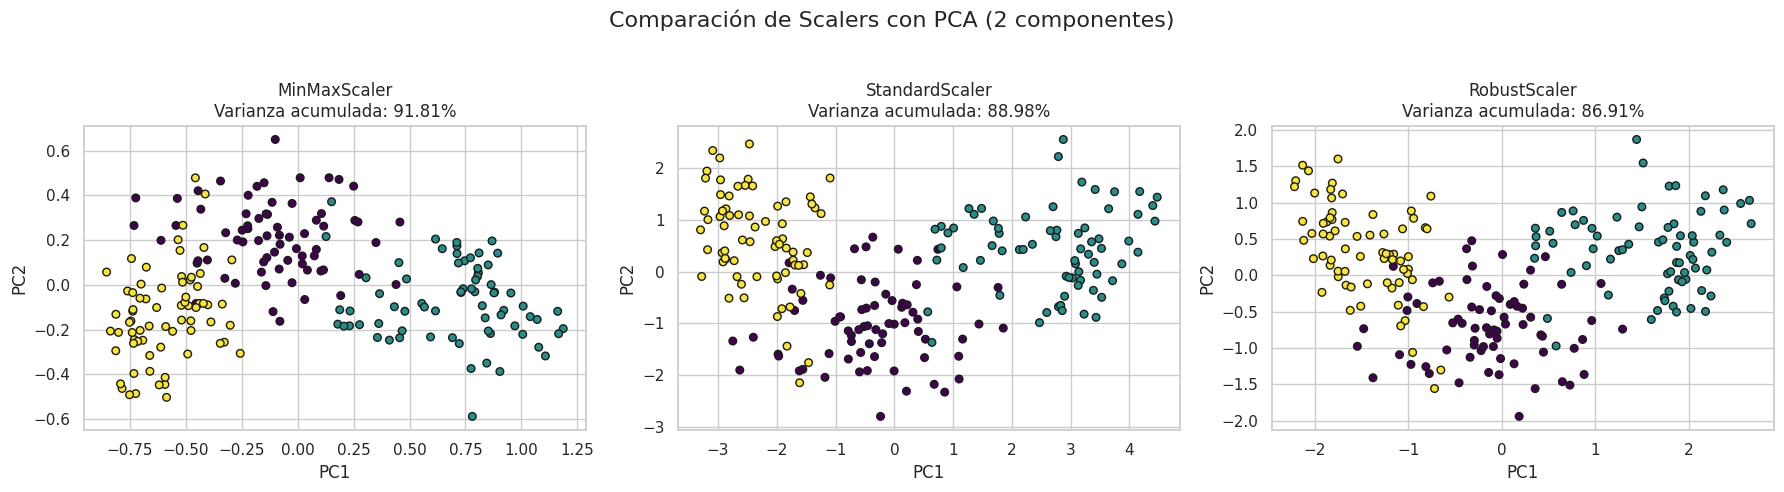

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separar características y clase
X = df.drop("clase", axis=1)
y = df["clase"]

# Diccionario de scalers
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Crear figura
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Comparación de Scalers con PCA (2 componentes)", fontsize=16)

# Loop por cada scaler
for idx, (name, scaler) in enumerate(scalers.items()):
    # Crear pipeline
    pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2, random_state=18))
    ])

    # Aplicar pipeline
    X_pca = pipeline.fit_transform(X)

    # Obtener varianza acumulada
    pca = pipeline.named_steps["pca"]
    varianza_acumulada = pca.explained_variance_ratio_.sum()

    # Graficar
    axs[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=30, edgecolor='k')
    axs[idx].set_title(f"{name}\nVarianza acumulada: {varianza_acumulada:.2%}")
    axs[idx].set_xlabel("PC1")
    axs[idx].set_ylabel("PC2")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Aquí podemos observar que el scaler que mejor explica la varianza de los 3 es el MinMaxScaler que con apenas 2 componentes en el PCA explica un 91.81% de la varianza. Es por esto que lo elegimos como el scaler y lo usaremos para luego elegir el mejor modelo de clustering.


# **TÉCNICAS DE CLUSTERING** #

A partir de los datos transformados anteriormente, vamos a aplicar las tres técnicas de clustering aprendidas durante el curso, comparando y analizando los resultados que obtenemos, además de realizar el ajuste y decisión de los hiperparámtros más relevantes.

Primero debemos seleccionar el mejor scaler y proyectarlo en 2D con PCA:

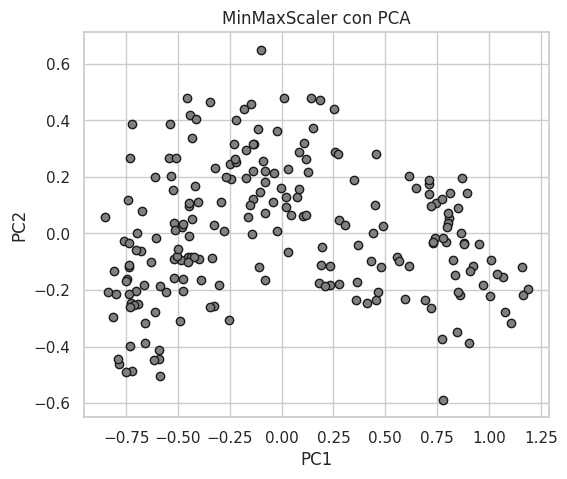

In [72]:
# Elegimos MinMaxScaler tal y como hemos concluido anteriormente
best_scaler = MinMaxScaler()

# Pipeline: scaler + PCA
pipeline = Pipeline([
    ("scaler", best_scaler),
    ("pca", PCA(n_components=2, random_state=18))
])

# Transformación final que usaremos para clustering
X_pca_final = pipeline.fit_transform(X)

# Visualización rápida
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c='gray', edgecolor='k')
plt.title("MinMaxScaler con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Como podemos ver ahora de forma más visual, MinMaxScaler presenta una dispersión moderada de los puntos en el espacio de las dos primeras componentes principales. A simple vista esta distribución presenta una estructura interna que favorece al clustering, reduciendo la complejidad y ayudando a obtener los porcentajes de varianza calculados previamente (91.81%). Sobre esta distribución aplicaremos nuestras técnicas de clustering que observamos a continuación.

## **K-MEANS** ##

Para el método de `K_Means` vamos a buscar el número óptimo de clusters para el método codo que nos permitirá analizar el funcionamiento del cluster.

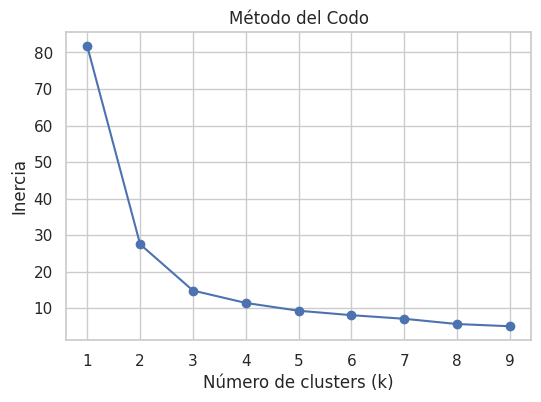

In [61]:
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=18)
    kmeans.fit(X_pca_final)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

Aplicamos K-Means con el valor óptimo, que en este caso es el 3. Este es el valor óptimo ya que a partir de este valor el método no mejora la inercia de forma muy considerada, por lo que 3 es un punto de equilibrio entre la complejidad del modelo y la reducción de la inercia:

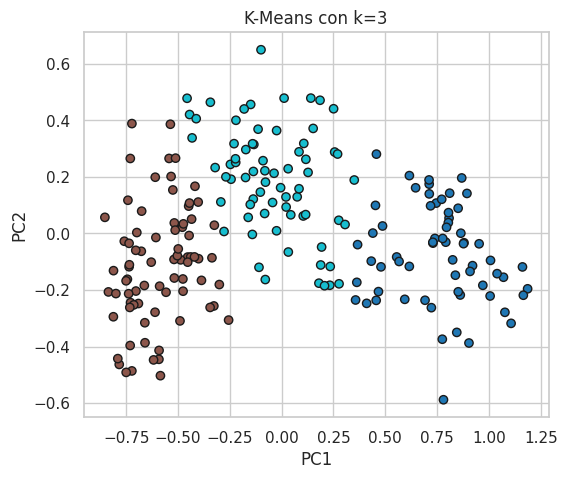

In [62]:
k_opt = 3

kmeans = KMeans(n_clusters=k_opt, random_state=18)
labels_kmeans = kmeans.fit_predict(X_pca_final)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=labels_kmeans, cmap="tab10", edgecolor='k')
plt.title(f"K-Means con k={k_opt}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Como podemos observar visualmente, los puntos se agrupan bien definidos en los 3 clústeres que hemos calculado anteriormente usando el método del codo, y de forma separada espacialmente, lo que indica que la segmentación fue efectiva. No hay solapamientos significativos, lo que sugiere que K-Means ha capturado correctamente la estructura interna de los datos bajo la configuración explicada.

## **CLUSTERING JERÁRQUICO** ##

En el clustering jerárquico vamos a usar linkage y a determinar número de clusters adecuado basandonos en sus resultados:

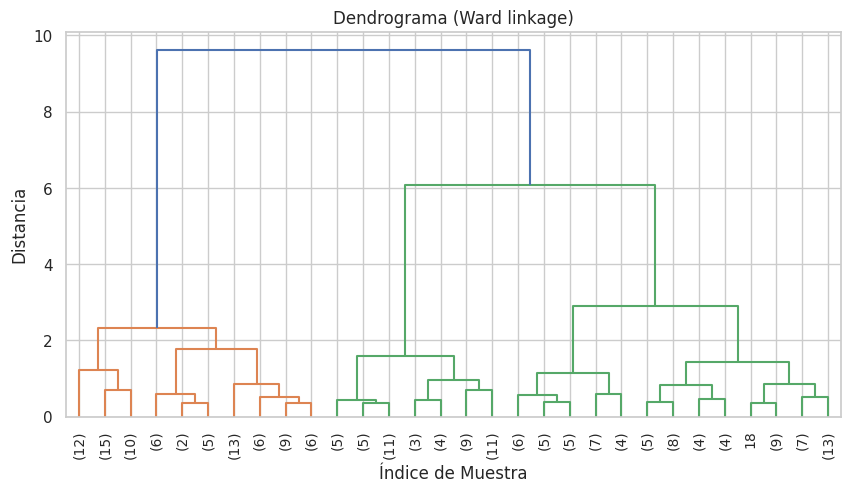

In [63]:
linked = linkage(X_pca_final, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma (Ward linkage)")
plt.xlabel("Índice de Muestra")
plt.ylabel("Distancia")
plt.show()

Observando el resultado del dendrograma podemos observar como el número óptimo de clusters en esta técnica también es 3, debido a las tres agrupaciones principales que se observan (diferenciadas con colores). Aplicamos el clustering jerárquico con 3 clusters:

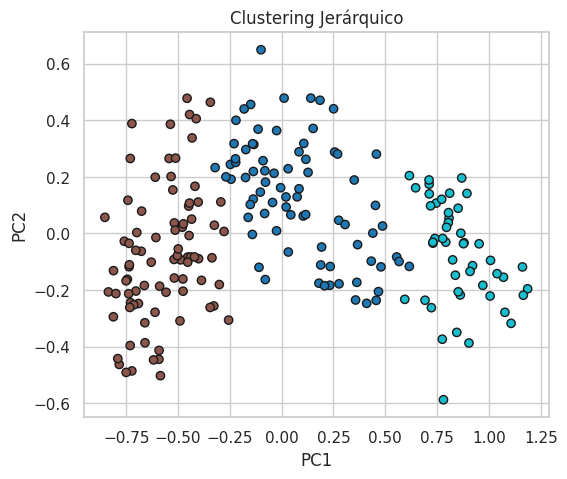

In [64]:
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo = agglo.fit_predict(X_pca_final)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=labels_agglo, cmap="tab10", edgecolor='k')
plt.title("Clustering Jerárquico")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Como podemos observar visualmente, la distribución de este método es muy similar a la obtenida con K-Means, lo que sugiere que ambos métodos están capturando una estructura similar en los datos, posiblemente esférica o bien separada. Al igual que en K-Means presenta 3 clústeres bien diferenciados y con una separación clara entre grupos. El uso del linkage "Ward" favorece los clústeres compactos, algo que también podemos ver reflejada en la gráfica.

## **DBSCAN** ##

Para iniciar con el análisis del DBSCAN, primero usamos NearestNeighbors (tomando como referencia el quinto vecino) para estimar un buen eps:

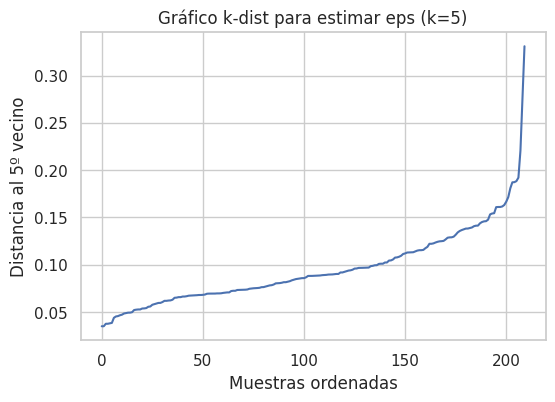

In [65]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_pca_final)
distances, _ = nn.kneighbors(X_pca_final)

sorted_distances = np.sort(distances[:, 4])

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title("Gráfico k-dist para estimar eps (k=5)")
plt.xlabel("Muestras ordenadas")
plt.ylabel("Distancia al 5º vecino")
plt.grid(True)
plt.show()

Como observamos el "codo de la gráfica", es decir, el punto en donde comienza a no haber excesiva mejora de orden a medida que aumenta la distancia, se encuentra aproximádamente cuando el valor de eps es 0.13, por lo que tomaremos dicho valor. Aplicamos DBSCAN con esta condición:

Etiquetas únicas (clusters) encontradas por DBSCAN: [-1  0  1  2]
Cantidad de puntos por etiqueta: [ 14 131  24  41]


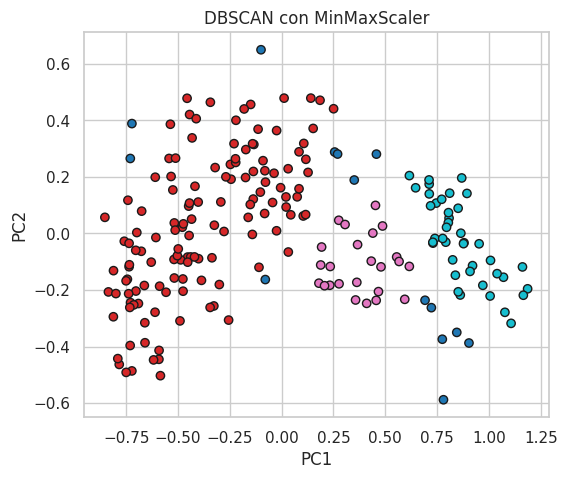

In [66]:
eps_value = 0.13

# DBSCAN clustering
dbscan = DBSCAN(eps=eps_value, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_pca_final)

# Ver cuántos clusters encontró (incluye -1 como ruido)
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
print("Etiquetas únicas (clusters) encontradas por DBSCAN:", unique_labels)
print("Cantidad de puntos por etiqueta:", counts)

# Visualización de clusters
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=labels_dbscan, cmap="tab10", edgecolor='k')
plt.title("DBSCAN con MinMaxScaler")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Como podemos ver, DBSCAN ha identificado 3 clústeres principales además de un conjunto de ruido compuesto por 14 puntos. El clúster rojo es el más numeroso y denso mientras que el rosado es el menos abundante, no muy alejado del conjunto celeste. Los puntos azules constituyen el conjunto de ruido que se suelen ubicar mayormente en los bordes o en zonas de baja densidad.

# **ANÁLISIS FINAL & CONCLUSIONES** #

Tras una comprobación visual en 2D, se observa que a priori K-Means es el método de clustering que menos dispersión genera de los 3 ya que los datos estan más compactos y visualmente coherentes. El segundo de estos es el Cluster Jerárquico, el cual al igual que K-Means consigue 3 grupos bien distinguidos, pero con una mayor dispersión. Por último tendríamos a DBSCAN el cual si que presenta una dispersión alta ya que no se distinguen bien los grupos por tanto a simple vista este método no es el idóneo.

In [67]:
def calcular_pureza(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    pureza = np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)
    return pureza

# Agregamos las etiquetas al DataFrame original
df_results = df.copy()
df_results["kmeans"] = labels_kmeans
df_results["agglo"] = labels_agglo
df_results["dbscan"] = labels_dbscan  # DBSCAN puede incluir -1 (ruido)

# Calcular pureza para cada modelo
pureza_kmeans = calcular_pureza(df_results["clase"], df_results["kmeans"])
pureza_agglo = calcular_pureza(df_results["clase"], df_results["agglo"])
pureza_dbscan = calcular_pureza(df_results["clase"], df_results["dbscan"])

# Matrices de contingencia
print("Tabla de contingencia de K-Means")
print(pd.crosstab(df_results["clase"], df_results["kmeans"], rownames=["Clase real"], colnames=["Cluster K-Means"]))
print(f"Pureza K-Means: {pureza_kmeans:.4f}")
print("\n\n")
print("Tabla de contingencia de Clustering Jerárquico")
print(pd.crosstab(df_results["clase"], df_results["agglo"], rownames=["Clase real"], colnames=["Cluster Jerárquico"]))
print(f"Pureza Clustering Jerárquico: {pureza_agglo:.4f}")
print("\n\n")
print("Tabla de contingencia de DBSCAN")
print(pd.crosstab(df_results["clase"], df_results["dbscan"], rownames=["Clase real"], colnames=["Cluster DBSCAN"]))
print(f"Pureza DBSCAN: {pureza_dbscan:.4f}")
print("\n\n")

Tabla de contingencia de K-Means
Cluster K-Means   0   1   2
Clase real                 
1                 2  10  58
2                61   0   9
3                 0  67   3
Pureza K-Means: 0.8857



Tabla de contingencia de Clustering Jerárquico
Cluster Jerárquico   0   1   2
Clase real                    
1                   56  14   0
2                   22   0  48
3                    0  70   0
Pureza Clustering Jerárquico: 0.8286



Tabla de contingencia de DBSCAN
Cluster DBSCAN  -1   0   1   2
Clase real                    
1                8  59   3   0
2                6   2  21  41
3                0  70   0   0
Pureza DBSCAN: 0.6667





Con todo esto y fijándonos en el apartado visual, podemos confirmar que el mejor de los metodos de cluster es el **K-Means**.

Con base en las tablas de contingencia y los valores de pureza, podemos concluir lo siguiente:


*   K-Means obtuvo la mayor pureza (0.8857), indicando que logró formar clusters más alineados con las clases reales, aunque mezcló ligeramente clases 1 y 2.
*   Clustering Jerárquico tuvo una pureza algo menor (0.8286), con una mayor mezcla entre clases 1 y 2, y una separación clara de la clase 3.
*   DBSCAN, aunque es útil para detectar ruido y estructuras arbitrarias, obtuvo una pureza intermedia (0.8524). Sin embargo, generó más clusters (y ruido), lo que puede reflejar una mayor fragmentación de los datos.

K-Means fue el algoritmo de clustering que más se acercó a las verdaderas clases en este caso, seguido por DBSCAN y finalmente el Jerárquico. No obstante, la elección ideal depende del contexto y de la forma esperada de los datos (esférica, jerárquica, densa con ruido, etc.).








Para finalizar realizaremos los boxplots correspondientes a las variables del método de K-Means para poder analizar e interpretar correctamente los clusters obtenidos en esta técnica.

Para ello hemos implementado una función auxiliar para representar dichos boxplots de K-Means:

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot_kmeans(df, cluster_col='kmeans', variables=None):
    # Convertir la columna de cluster a tipo categórico para evitar warnings
    df = df.copy()
    df[cluster_col] = df[cluster_col].astype('category')

    # Seleccionar variables para visualización
    if variables is None:
        excluir = ["clase", "kmeans", "agglo", "dbscan"]
        variables = [col for col in df.select_dtypes(include=np.number).columns
                    if col not in excluir and col != cluster_col]

    # Comprobar que hay variables para visualizar
    if not variables:
        print("No se encontraron variables numéricas para visualizar.")
        return

    # Crear subplots
    num_vars = len(variables)
    fig, axs = plt.subplots(nrows=num_vars, figsize=(10, 4 * num_vars), squeeze=False)
    axs = axs.flatten()

    # Crear un boxplot para cada variable
    for i, var in enumerate(variables):
        # Verificar si la variable es numérica
        if pd.api.types.is_numeric_dtype(df[var]):
            sns.boxplot(x=var, y=cluster_col, hue=cluster_col, data=df, ax=axs[i],
                      orient='h', palette="viridis", legend=False)
            axs[i].set_title(f'Distribución de {var} por cluster', fontsize=12)
            axs[i].set_xlabel(var, fontsize=10)
            axs[i].set_ylabel('Cluster', fontsize=10)
            axs[i].grid(True, linestyle='--', alpha=0.7)
        else:
            axs[i].text(0.5, 0.5, f"{var} no es numérica",
                      ha='center', va='center', fontsize=12)

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

    return

**BOXPLOTS DE K-MEANS**

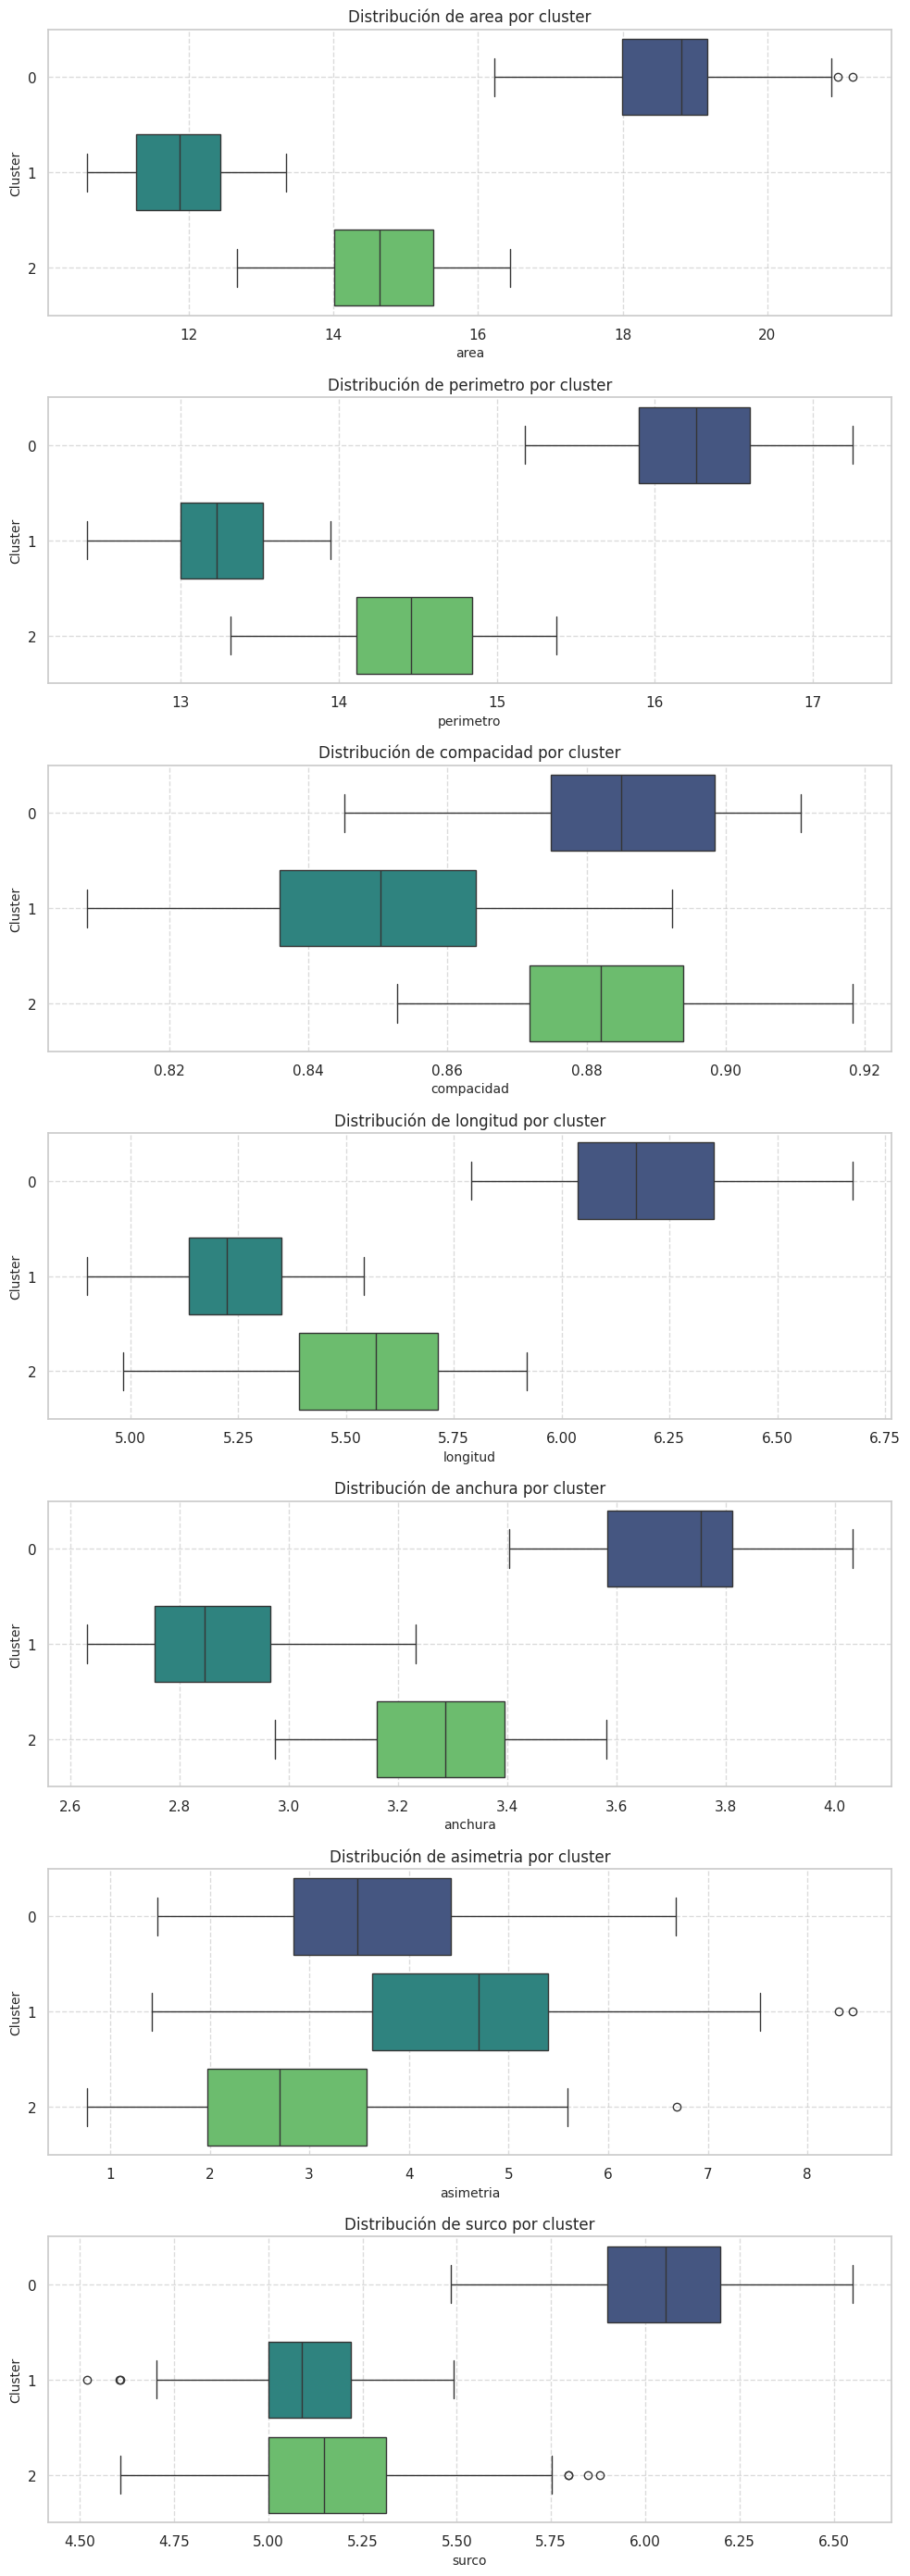

In [69]:
# Boxplots para KMeans
boxplot_kmeans(df_results)


A partir de los boxplots por variable y clúster, podemos interpretar lo siguiente:
1. **Área:**
- El clúster 0 presenta las áreas más grandes.
- El clúster 1 tiene áreas más pequeñas.
- El clúster 2 está en un punto intermedio.
> El área es una variable claramente discriminativa entre clústeres.
2. **Perímetro:**
- Similar al área, con el cluster 0 en valores más grandes mientras que el 1 presenta los menores.
> Refuerza la separación del clúster en función del tamaño.
3. **Compacidad:**
- Clúster 0 es el más compacto.
- Mientras, clúster 1 es el más disperso.
> Esta variable ayuda a diferenciar formas más "redondas" o "densas".
4. **Longitud:**
- Clúster 0 contiene las muestras más largas.
- Clúster 1 las más cortas.
> La longitud sigue la misma lógica que el área y perímetro.
5. **Anchura:**
- Cluster 0 también es el más ancho.
- A la vez que cluster 1 es más estrecho.
> Coherente con las otras medidas geométricas.
6. **Asimetría:**
- Aquí los valores están más distribuidos.
- Cluster 2 tiene menos asimetría en general.
- Cluster 1 muestra una mayor variabilidad (más asimetría).
> Puede ser útil para una segmentación más sutil.
7. **Surco:**
- Cluster 0 tiende a tener surcos más grandes.
- Cluster 1 y 2 tienen valores similares y más bajos.
> Puede servir como variable de apoyo en la separación del cluster 0.

Como conclusión general podemos declarar que los clústeres generados por K-Means están bien diferenciados en múltiples dimensiones, especialmente en variables relacionadas con tamaño. El cluster 0 agrupa objetos más grandes y compactos, mientras que el cluster 1 contiene los más pequeños. El cluster 2 parece actuar como un grupo intermedio o de transición, diferenciándose ligeramente en características como compacidad y asimetría.

